In [1]:
import numpy as np 
import pandas as pd
import joblib
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")

2024-01-27 17:14:31.592016: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 17:14:31.594054: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 17:14:31.619340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 17:14:31.619375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 17:14:31.620363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Data Preprocessing

In [2]:
df = pd.read_csv('Luxury watch.csv')
df

,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,"9,500"
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,"5,800"
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,"4,200"
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,"7,900"
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,NaN,NaN,"2,800"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Breguet,Classique,18k Rose Gold,Leather,Automatic,30 meters,38.5,8.25,20.0,White,Sapphire,Date,38 hours,"21,500"
503,Blancpain,Fifty Fathoms,Stainless Steel,Fabric,Automatic,300 meters,45.0,15.50,23.0,Black,Sapphire,Date,120 hours,"13,500"
504,Longines,Master Collection,Stainless Steel,Leather,Automatic,30 meters,38.5,9.70,20.0,Blue,Sapphire,Date,64 hours,"1,800"
505,Vacheron Constantin,Overseas,Stainless Steel,Stainless Steel,Automatic,150 meters,41.5,11.00,22.0,Blue,Sapphire,Date,40 hours,"19,000"


### Make the target column, water resistance and power reserve to be of type float instead of object

In [3]:
df['Price (USD)'] = df['Price (USD)'].apply(lambda x: float(str(x).replace(',','')))

df['Water Resistance'] = df['Water Resistance'].apply(lambda x: float(str(x).replace('meters', '')))

# Function to convert days to hours
def convert_days_to_hours(value):
    if pd.notna(value):  # Check if the value is not NaN
        if 'days' in value:
            days = int(value.split()[0])
            return days * 24
        elif 'hours' in value:
            return int(value.split()[0])
        else: return np.nan
    else:
        return value  # Return NaN if the input is NaN
# Apply the function to the 'Power Reserve' column
df['Power Reserve'] = df['Power Reserve'].apply(convert_days_to_hours)
df['Power Reserve'] = df['Power Reserve'].apply(lambda x: float(str(x).replace('hours', '')))

### Remove rows that contain nan values

In [4]:
df.dropna(inplace=True)

### Remove duplicated rows

In [5]:
df = df.drop_duplicates()

### Create column transformer

In [6]:
targetcol = 'Price (USD)'
X = df.loc[:,~df.columns.isin([targetcol])]
y = df.loc[:,df.columns.isin([targetcol])]
catcols = list(X.select_dtypes(include=['object']).columns)
numcols = list(X.select_dtypes(include=['float64','int']).columns)

In [7]:
numcols

['Water Resistance',
 'Case Diameter (mm)',
 'Case Thickness (mm)',
 'Band Width (mm)',
 'Power Reserve']

In [8]:
catcols

['Brand',
 'Model',
 'Case Material',
 'Strap Material',
 'Movement Type',
 'Dial Color',
 'Crystal Material',
 'Complications']

In [9]:
class LowercaseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Assuming X is a DataFrame
        for column in X.select_dtypes(include='object').columns:
            X[column] = X[column].str.lower()
        return X

In [10]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("lowercase", LowercaseTransformer()),  # Custom transformer for lowercase
    ("imputer", SimpleImputer(strategy="constant")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ("selector", SelectPercentile(chi2, percentile=50)),
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numcols),
        ("cat", categorical_transformer, catcols),
    ]
)

# Models

### Split the dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define models 

In [12]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
etree = ExtraTreesRegressor()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
knn = KNeighborsRegressor()
svr = SVR(kernel='linear', C=1.0)
lgbm = lgb.LGBMRegressor()
mlp = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)


Models = [lr, ridge, lasso, tree, rf, etree, gb, xgb, knn, svr, lgbm, mlp]

### Test models

In [13]:
results = pd.DataFrame()

for model in Models:
    print('Model is: {}'.format(model))
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("model", model)]
    )
    m = pipeline.fit(X_train, y_train)
    print('Training score : {}'.format(m.score(X_train, y_train)))
    prediction = m.predict(X_test)

    r2score = r2_score(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    print('R2 score : {}'.format(r2score))
    print('MAE : {}'.format(mae))
    print('MSE : {}'.format(mse))
    print('RMSE : {}'.format(rmse))

    model_df = pd.DataFrame({'Model Name': [model], 'R2 score': [r2score], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    results = pd.concat([results, model_df], ignore_index=True)
    
    print('=' * 80)
    
results = results.sort_values(by='RMSE', ascending=True)
display(results)

Model is: LinearRegression()
Training score : 0.9202830385707339
R2 score : -0.544205703304232
MAE : 4265.13857469921
MSE : 231392104.26139402
RMSE : 15211.577967502057
Model is: Ridge()
Training score : 0.908454431831281
R2 score : 0.8259832912985446
MAE : 2747.5182209611507
MSE : 26075601.402657654
RMSE : 5106.427459844863
Model is: Lasso()
Training score : 0.918487907739911
R2 score : 0.8293136431383586
MAE : 2638.4985878648217
MSE : 25576563.535813607
RMSE : 5057.327706982573
Model is: DecisionTreeRegressor()
Training score : 0.9696218013970933
R2 score : 0.858613519272628
MAE : 2628.2207207207202
MSE : 21186112.1996997
RMSE : 4602.8374074802705
Model is: RandomForestRegressor()
Training score : 0.9529097530882946
R2 score : 0.8537215823101066
MAE : 2609.1062318312315
MSE : 21919146.39666568
RMSE : 4681.788803082181
Model is: ExtraTreesRegressor()
Training score : 0.9696218013970933
R2 score : 0.8692925570668069
MAE : 2439.6369369369363
MSE : 19585907.627605084
RMSE : 4425.59686681

,Model Name,R2 score,MAE,MSE,RMSE
5,"(ExtraTreeRegressor(random_state=543101027), E...",0.869293,2439.636937,1.958591e+07,4425.596867
3,DecisionTreeRegressor(),0.858614,2628.220721,2.118611e+07,4602.837407
4,"(DecisionTreeRegressor(max_features=1.0, rando...",0.853722,2609.106232,2.191915e+07,4681.788803
7,"XGBRegressor(base_score=None, booster=None, ca...",0.853304,2647.418477,2.198176e+07,4688.471036
2,Lasso(),0.829314,2638.498588,2.557656e+07,5057.327707
1,Ridge(),0.825983,2747.518221,2.607560e+07,5106.427460
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.810560,2805.575721,2.838666e+07,5327.913739
8,KNeighborsRegressor(),0.800782,3177.554054,2.985191e+07,5463.690121
10,LGBMRegressor(),0.738694,3600.264346,3.915545e+07,6257.431536
9,SVR(kernel='linear'),-0.240475,8202.314980,1.858794e+08,13633.759928


### Neural Network

Epoch 1/140
10/10 [==============================] - 0s 1ms/step - loss: 263616768.0000
Epoch 2/140
10/10 [==============================] - 0s 1ms/step - loss: 263609696.0000
Epoch 3/140
10/10 [==============================] - 0s 1ms/step - loss: 263601696.0000
Epoch 4/140
10/10 [==============================] - 0s 1ms/step - loss: 263591856.0000
Epoch 5/140
10/10 [==============================] - 0s 958us/step - loss: 263577664.0000
Epoch 6/140
10/10 [==============================] - 0s 1ms/step - loss: 263557760.0000
Epoch 7/140
10/10 [==============================] - 0s 1ms/step - loss: 263530688.0000
Epoch 8/140
10/10 [==============================] - 0s 885us/step - loss: 263492880.0000
Epoch 9/140
10/10 [==============================] - 0s 970us/step - loss: 263440352.0000
Epoch 10/140
10/10 [==============================] - 0s 925us/step - loss: 263371904.0000
Epoch 11/140
10/10 [==============================] - 0s 958us/step - loss: 263283808.0000
Epoch 12/140
10/10 [

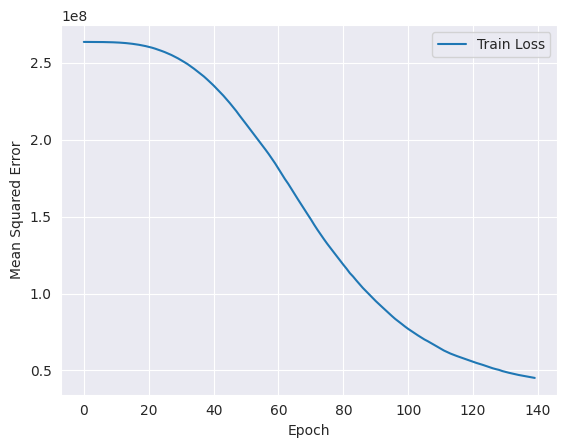

In [14]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = preprocessor.transform(X_test)

y_train_preprocessed = np.array(y_train, dtype=np.float32)
y_test_preprocessed = np.array(y_test, dtype=np.float32)

nn = model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])
nn.compile(optimizer='adam', loss='mean_squared_error')
history = nn.fit(X_train_preprocessed, y_train_preprocessed, epochs=140, batch_size=32, verbose=1)
prediction = nn.predict(X_test_preprocessed)

plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [15]:
r2score = r2_score(y_test_preprocessed, prediction)
mae = mean_absolute_error(y_test_preprocessed, prediction)
mse = mean_squared_error(y_test_preprocessed, prediction)
rmse = np.sqrt(mean_squared_error(y_test_preprocessed, prediction))
print('R2 score : {}'.format(r2score))
print('MAE : {}'.format(mae))
print('MSE : {}'.format(mse))
print('RMSE : {}'.format(rmse))

model_df = pd.DataFrame({'Model Name': [model], 'R2 score': [r2score], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
results = pd.concat([results, model_df], ignore_index=True)
results = results.sort_values(by='RMSE', ascending=True)
display(results)

R2 score : 0.5599514315538976
MAE : 4426.42138671875
MSE : 65939248.0
RMSE : 8120.29833984375


,Model Name,R2 score,MAE,MSE,RMSE
0,"(ExtraTreeRegressor(random_state=543101027), E...",0.869293,2439.636937,1.958591e+07,4425.596867
1,DecisionTreeRegressor(),0.858614,2628.220721,2.118611e+07,4602.837407
2,"(DecisionTreeRegressor(max_features=1.0, rando...",0.853722,2609.106232,2.191915e+07,4681.788803
3,"XGBRegressor(base_score=None, booster=None, ca...",0.853304,2647.418477,2.198176e+07,4688.471036
4,Lasso(),0.829314,2638.498588,2.557656e+07,5057.327707
5,Ridge(),0.825983,2747.518221,2.607560e+07,5106.427460
6,([DecisionTreeRegressor(criterion='friedman_ms...,0.810560,2805.575721,2.838666e+07,5327.913739
7,KNeighborsRegressor(),0.800782,3177.554054,2.985191e+07,5463.690121
8,LGBMRegressor(),0.738694,3600.264346,3.915545e+07,6257.431536
12,<keras.src.engine.sequential.Sequential object...,0.559951,4426.421387,6.593925e+07,8120.298340


# Final model

In [16]:
pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", etree)]
)
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Water Resistance',
                                                   'Case Diameter (mm)',
                                                   'Case Thickness (mm)',
                                                   'Band Width (mm)',
                                                   'Power Reserve']),
                                                 ('cat',
                                                  Pipeline(steps=[('lowercase',
                                                                   LowercaseTransformer()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7fa02e028ca0>))]),
                                                  ['Brand', 'Model',
                                                   'Case Material',
                                                   'Strap Material',
                                                   'Movement Type',
                                                   'Dial Color',
                                                   'Crystal Material',
                                                   'Complications'])])),
                ('model', ExtraTreesRegressor())])

In [17]:
joblib.dump(pipeline, "model.joblib")

['model.joblib']

In [18]:
joblib.dump(list(X.columns), 'model_column_names.joblib')

['model_column_names.joblib']